In [15]:
# Import libraries
import numpy as np 
import pandas as pd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import scipy.stats as stats

In [29]:
# Read in data
data = pd.read_csv("data/training.csv")

# Remove the NA values
data = data.drop('Unnamed: 12', axis=1)

# Rename columns to match test data
data = data.rename(columns={'TA1.x': 'TA1'})

# Get on test data
test_data = pd.read_csv('data/test.csv')


In [19]:
# Split the data into features and target variable
X = data.drop(['DIC'], axis=1)
y = data['DIC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')


X_train : (1163, 17)
y_train : (1163,)
X_test : (291, 17)
y_test : (291,)


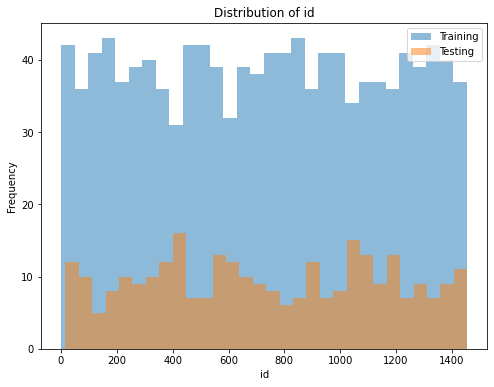

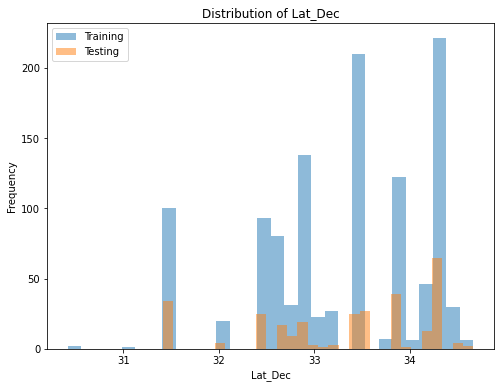

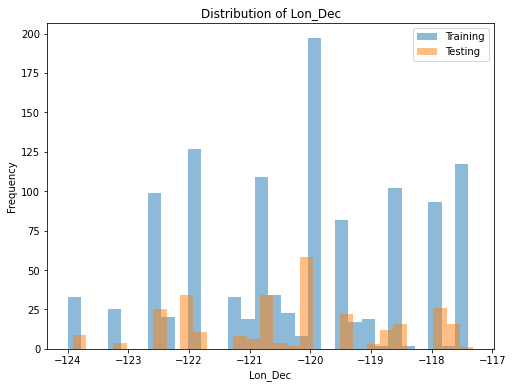

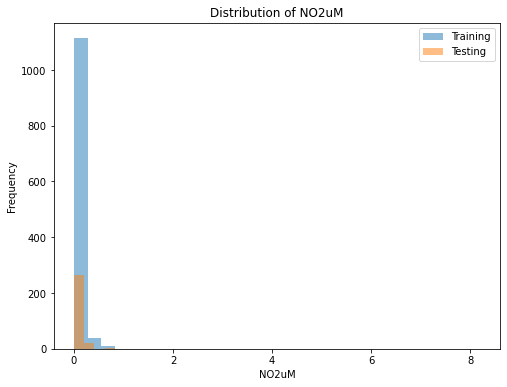

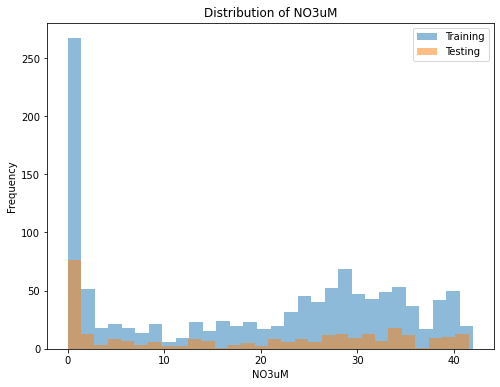

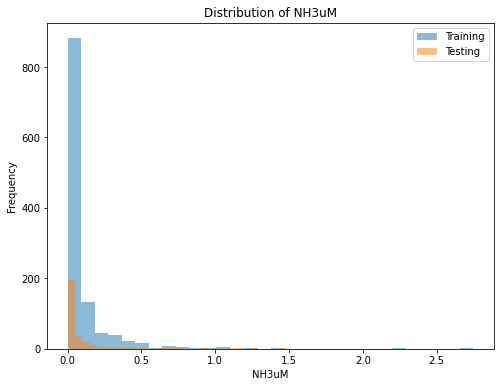

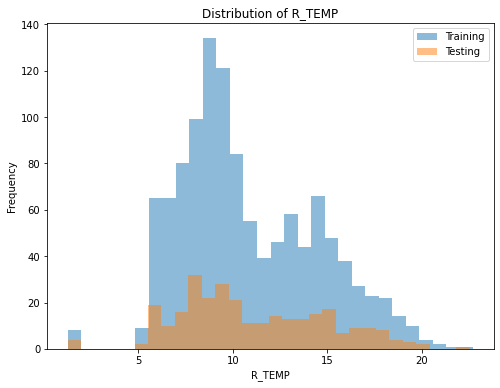

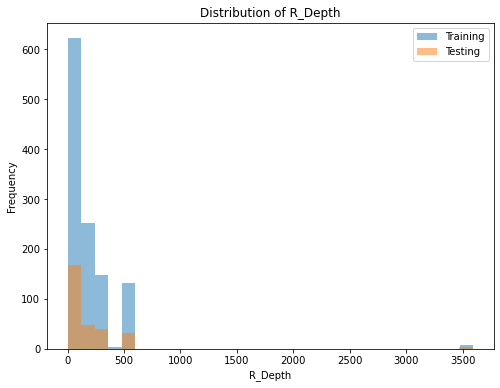

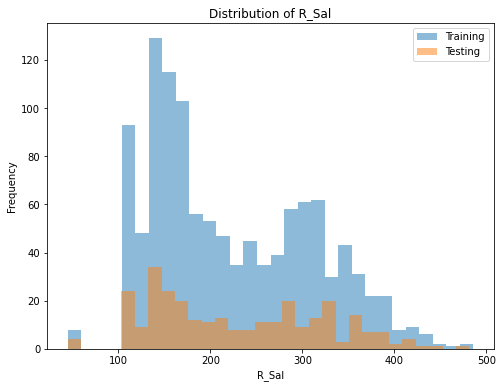

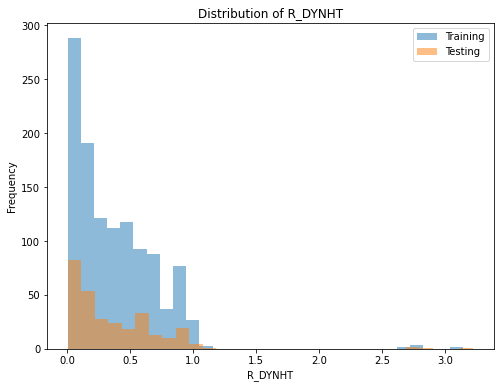

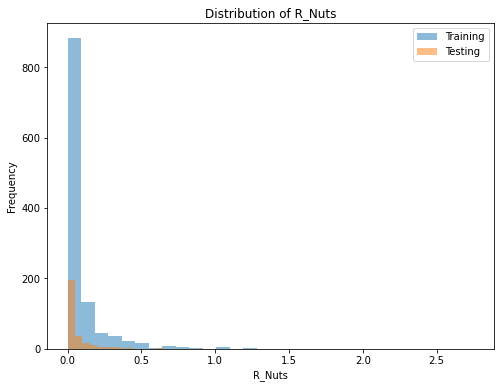

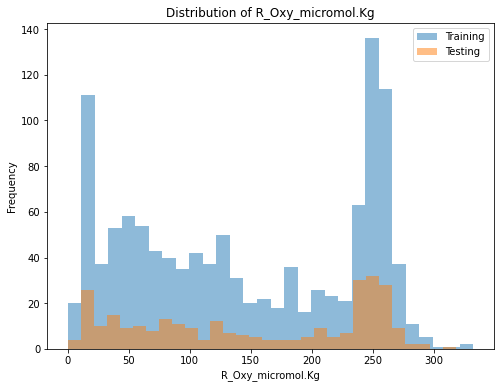

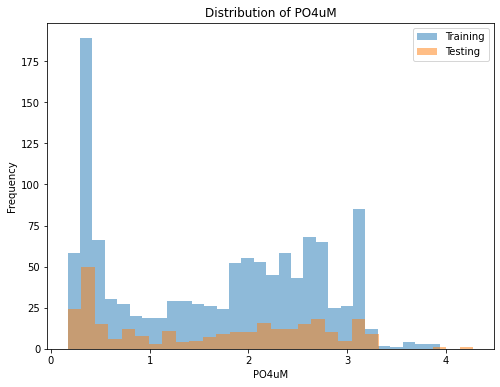

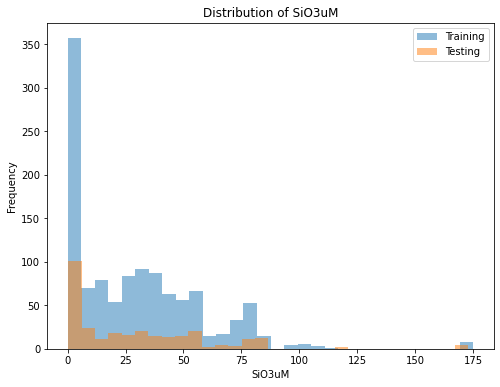

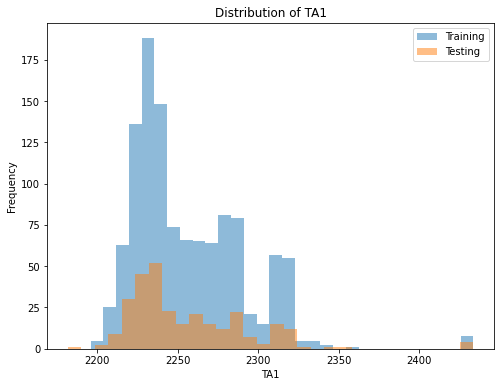

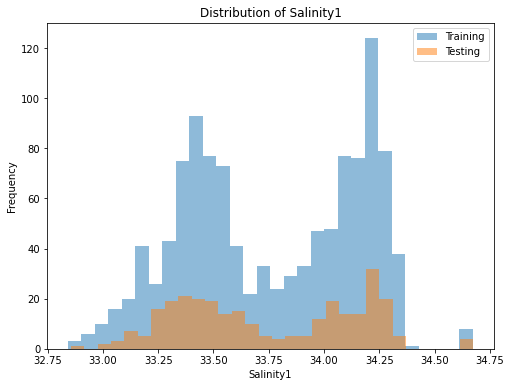

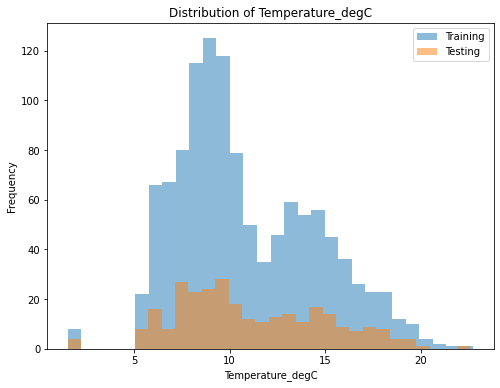

T-test results for id:
T-statistic: -0.3114
P-value: 0.7555
F-test results for id:
F-statistic: 0.0970
P-value: 0.7555

T-test results for Lat_Dec:
T-statistic: -0.2672
P-value: 0.7894
F-test results for Lat_Dec:
F-statistic: 0.0714
P-value: 0.7894

T-test results for Lon_Dec:
T-statistic: 1.1378
P-value: 0.2554
F-test results for Lon_Dec:
F-statistic: 1.2945
P-value: 0.2554

T-test results for NO2uM:
T-statistic: -1.0099
P-value: 0.3127
F-test results for NO2uM:
F-statistic: 1.0199
P-value: 0.3127

T-test results for NO3uM:
T-statistic: 1.1330
P-value: 0.2574
F-test results for NO3uM:
F-statistic: 1.2836
P-value: 0.2574

T-test results for NH3uM:
T-statistic: 0.3202
P-value: 0.7489
F-test results for NH3uM:
F-statistic: 0.1025
P-value: 0.7489

T-test results for R_TEMP:
T-statistic: -1.0468
P-value: 0.2954
F-test results for R_TEMP:
F-statistic: 1.0958
P-value: 0.2954

T-test results for R_Depth:
T-statistic: -0.6745
P-value: 0.5001
F-test results for R_Depth:
F-statistic: 0.4550
P-va

In [16]:
# Compare the distribution of features between training and testing data
for column in X_train.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(X_train[column], bins=30, alpha=0.5, label='Training')
    plt.hist(X_test[column], bins=30, alpha=0.5, label='Testing')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

# Perform statistical tests to compare means and variances
for column in X_train.columns:
    train_data = X_train[column]
    test_data = X_test[column]
    
    # Perform t-test to compare means
    t_statistic, p_value = stats.ttest_ind(train_data, test_data)
    print(f"T-test results for {column}:")
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Perform F-test to compare variances
    f_statistic, p_value = stats.f_oneway(train_data, test_data)
    print(f"F-test results for {column}:")
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    print()

# Calculate summary statistics for each feature in training and testing data
train_summary = X_train.describe()
test_summary = X_test.describe()

# Compare the summary statistics side by side
summary_comparison = pd.concat([train_summary, test_summary], axis=1, keys=['Training', 'Testing'])
print("Summary statistics comparison:")
print(summary_comparison)

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

<Figure size 864x720 with 0 Axes>

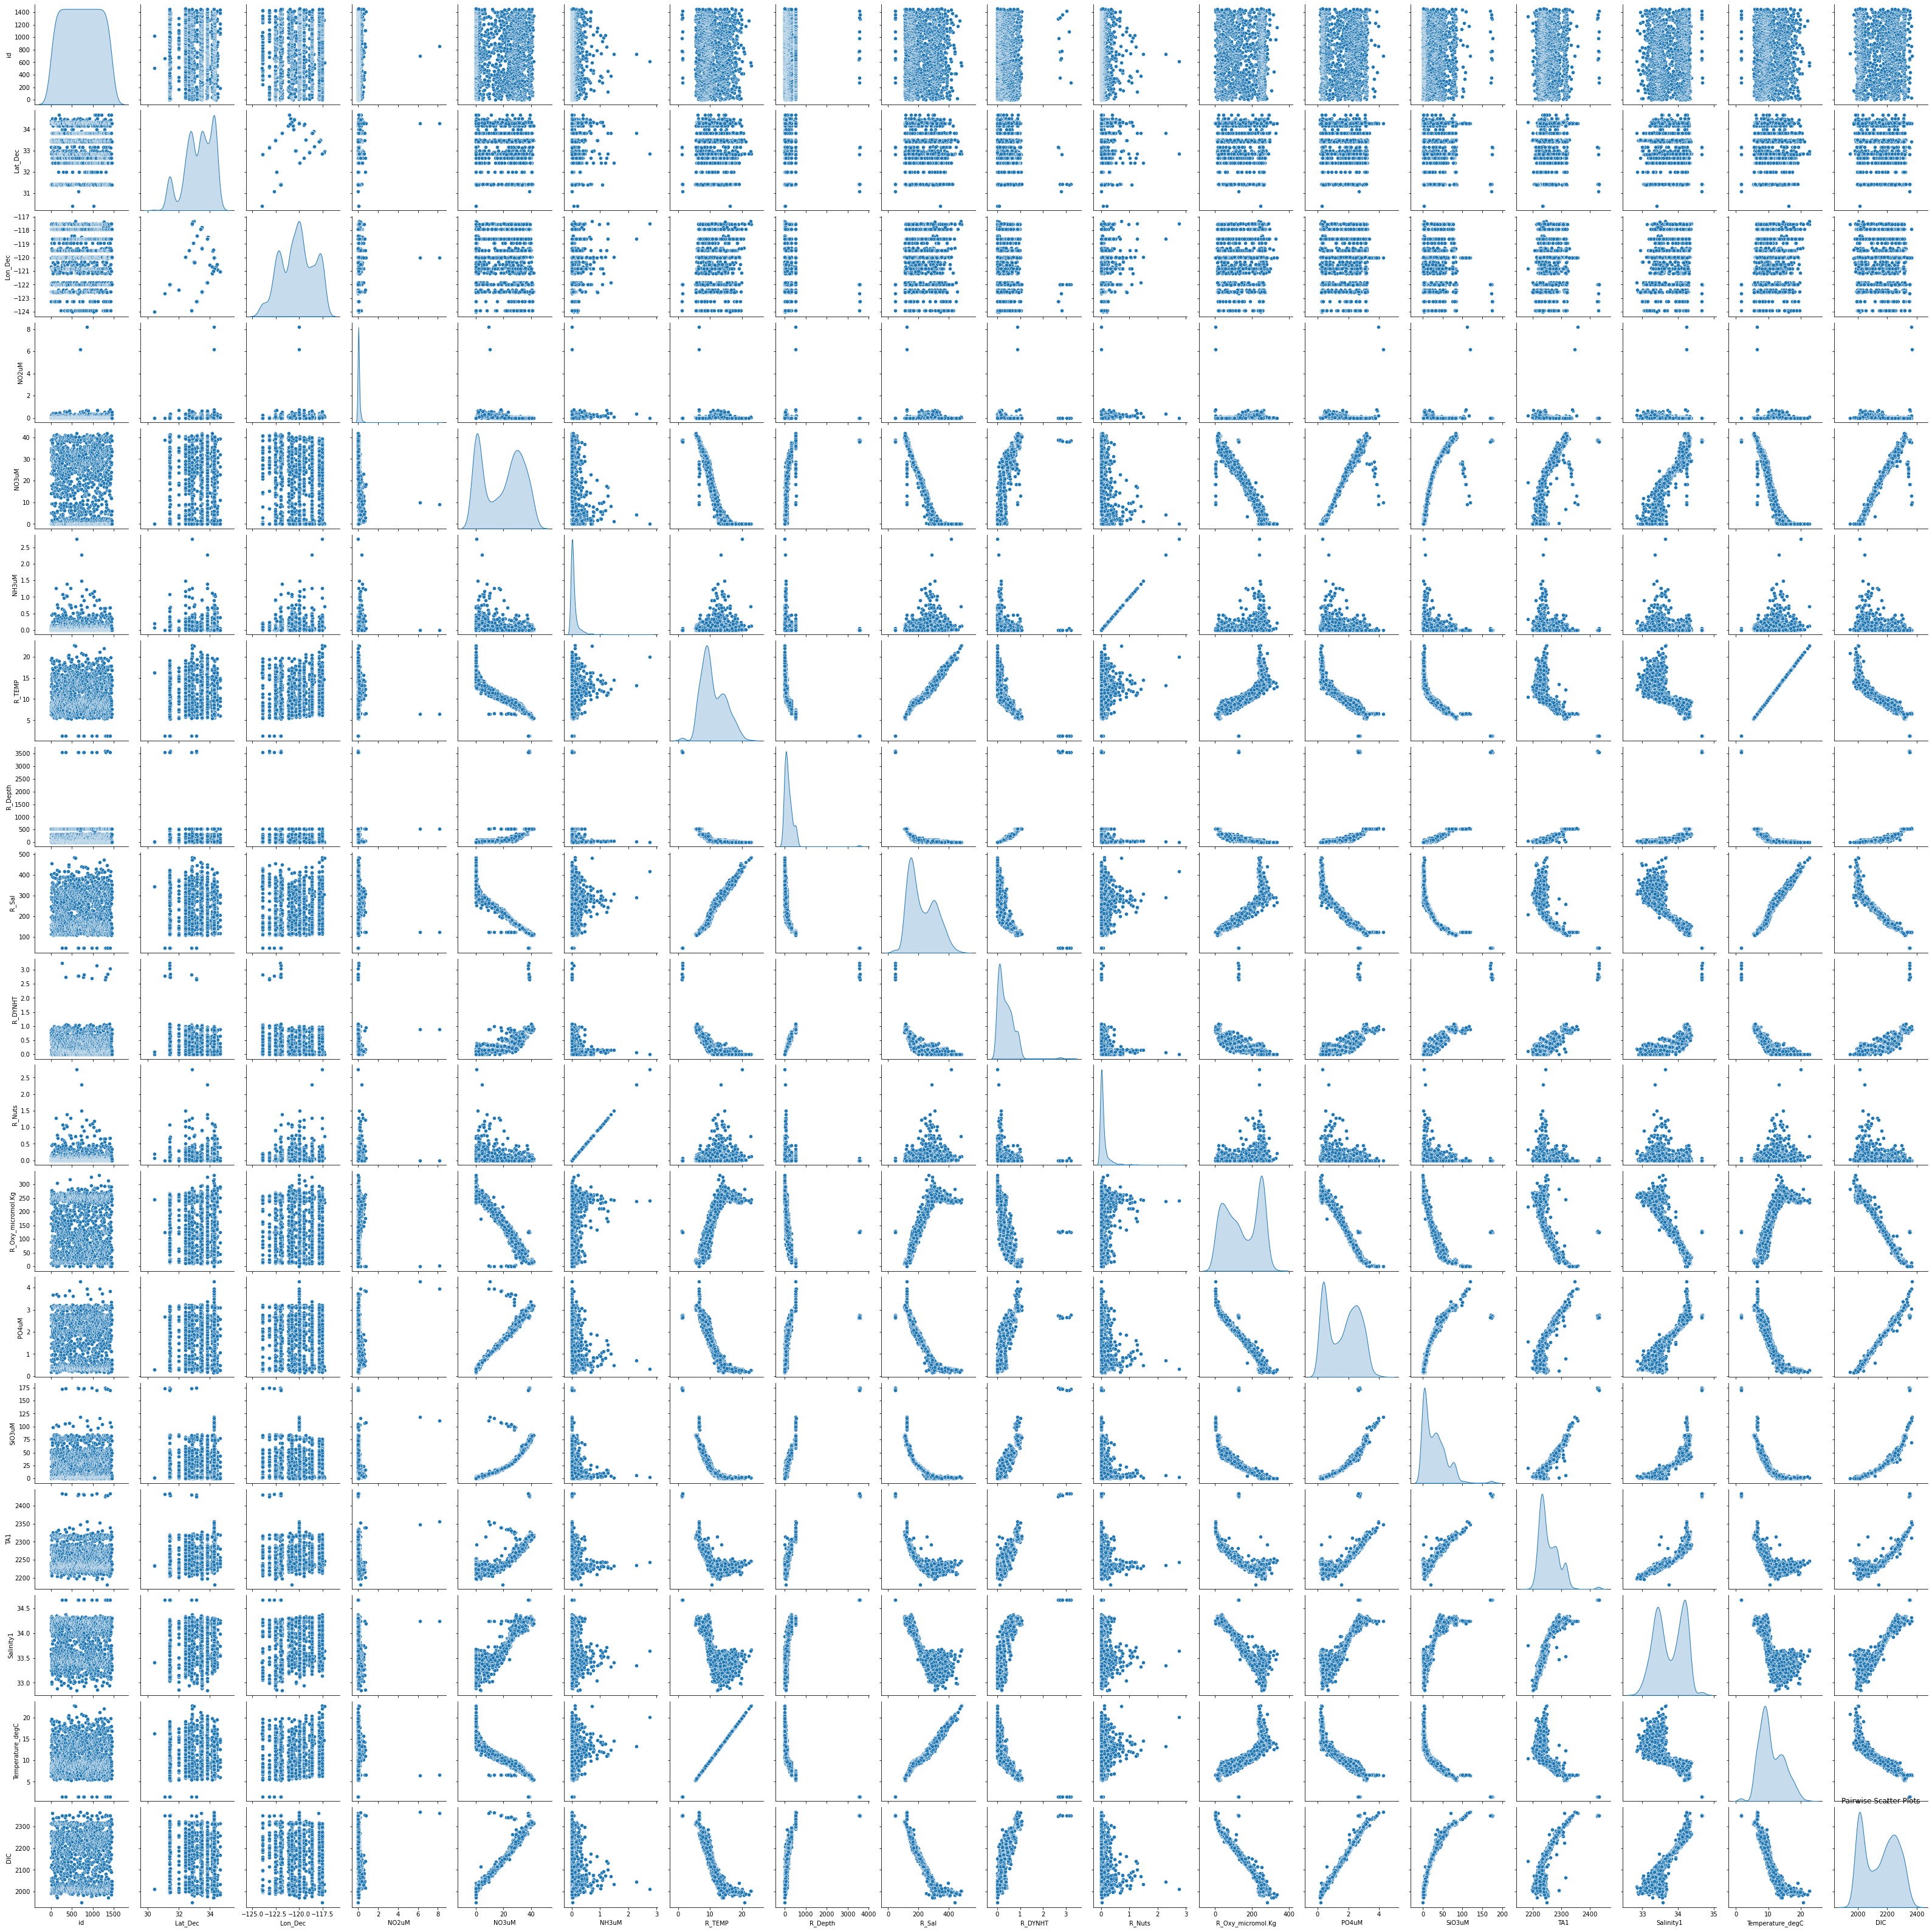

In [35]:
# Pairwise scatter plots
plt.figure(figsize=(12, 10))
sns.pairplot(data, diag_kind='kde')
plt.title('Pairwise Scatter Plots')
plt.show()

In [ ]:
# Ridge regression - not used for final submission

# Generate ridge
ridge = Ridge(random_state=42)

# Define the param grid for hyperparam tuning
param_grid_ridge = {
    'alpha': [3, 4, 5, 6, 7, 8],
    'max_iter': [200, 300, 400, 500, 600],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Perform grid search with cross-validation
grid_search_ridge = GridSearchCV(estimator=ridge, 
                                 param_grid=param_grid_ridge, 
                                 cv=5, 
                                 scoring='neg_mean_squared_error',
                                 verbose=1)
grid_search_ridge.fit(X_train, y_train)

# Pull the best model parameters
best_ridge = grid_search_ridge.best_estimator_
best_params_ridge = grid_search_ridge.best_params_

print("Best Ridge Parameters:", best_params_ridge)

# Predict using the best Ridge model
y_pred_train = best_ridge.predict(X_train)
y_pred_test = best_ridge.predict(X_test)

# Calculate training and testing RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Ridge - Training RMSE:", rmse_train)
print("Ridge - Testing RMSE:", rmse_test)

# Check for overfitting
if rmse_train < rmse_test:
    print("Warning: The model may be overfitting to the training data.")

# Prep OOB samples
test_data_features = test_data[X.columns]

# Make predictions on OOB samples
predictions_oob = best_ridge.predict(test_data_features)

# Prep submission 
submission_df = pd.DataFrame({
    'id': test_data['id'],
    'DIC': predictions_oob
})

# Save the submission to a CSV file
submission_csv_path = 'data/submission_ridge.csv'
# submission_df.to_csv(submission_csv_path, index=False)

In [41]:
# Random Forest -- not used for final submission

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 7, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create and train RF model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_grid_rf,
                                   n_iter=100,
                                   cv=10,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1,
                                   verbose=1)

# Fit RandomizedSearchCV on the training data
random_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print("Best RF Hyperparameters:", random_search_rf.best_params_)

# Make predictions on the testing data
y_pred = random_search_rf.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Perform cross-validation on the training data
scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
rmse_train = -np.mean(scores)
print(f"Training RMSE: {rmse_train:.4f}")

# Make predictions using the trained model
rf_model = RandomForestRegressor(**random_search.best_params_)
rf_model.fit(X, y)  
predictions = rf_model.predict(test_data)

# Create a submission 
submission_df = pd.DataFrame({'id': test_data['id'], 'DIC': predictions})

# Save the submission to a CSV file
#submission_df.to_csv('submission_rf.csv', index=False)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best RF Hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8}
Mean Squared Error: 38.8041412284038
Mean Absolute Error: 3.43074669995541
R-squared: 0.9970971453282959
Training RMSE: 6.0752


In [46]:
# XGB -- for submission

# Convert into a data structure that XGBoost supports
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost model
params_xgb = {
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'objective': 'reg:squarederror',  
    'random_state': 42
}

# Specify the number of CV folds and metrics for evaluation
cv_results_xgb = xgb.cv(
    dtrain=dtrain,
    params=params_xgb,
    nfold=10,
    num_boost_round=500,  # The number of boosting rounds or trees to build
    early_stopping_rounds=50,  # Stop if the metric does not improve in these many rounds
    metrics="rmse",  
    as_pandas=True,
    seed=13
)

# Display CV results
print(cv_results_xgb)

best_num_boost_round_xgb = len(cv_results_xgb)

# Train model with the best number of boosting rounds
xgb_model = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round_xgb
)

# Predict on the test set
predictions = xgb_model.predict(dtest)

# Evaluate the final model 
final_mse_cv = cv_results_xgb['test-rmse-mean'].iloc[-1] # Last row's RMSE squared to get MSE
print("Root Mean Squared Error:", final_mse_cv)

# Make sure correct features used
test_data_features = test_data[X.columns]  # Assuming 'X.columns' contains the correct features

# Create a DMatrix for the actual test data 
dtest_actual = xgb.DMatrix(test_data_features)

# Use the trained model to predict test data we are given
predictions_actual_test_data = xgb_model.predict(dtest_actual)

submission_df = pd.DataFrame({
    'id': test_data['id'],  
    'DIC': predictions_actual_test_data
})

submission_csv_path = 'submission_xgb.csv' 
submission_df.to_csv(submission_csv_path, index=False)

/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         106.929859        0.415297      106.957687       3.831066
1         101.675777        0.397700      101.698833       3.684700
2          96.687255        0.378681       96.705181       3.534583
3          91.949535        0.357394       91.945765       3.392269
4          87.458782        0.343595       87.475191       3.227124
..               ...             ...             ...            ...
409         1.068305        0.031213        5.667779       1.533686
410         1.066067        0.030823        5.667387       1.533576
411         1.062982        0.030174        5.667779       1.533400
412         1.059770        0.030201        5.668113       1.533099
413         1.057294        0.030207        5.667238       1.533464

[414 rows x 4 columns]


/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error: 5.667237921429102


In [42]:
# Ensemble -- not used for final prediction

# Create an ensemble model by averaging the predictions of Random Forest and XGBoost
ensemble_predictions_train = (random_search_rf.predict(X_train) + xgb_model.predict(dtrain)) / 2
ensemble_predictions_test = (random_search_rf.predict(X_test) + xgb_model.predict(dtest)) / 2

# Evaluate the ensemble model
rmse_train_ensemble = np.sqrt(mean_squared_error(y_train, ensemble_predictions_train))
rmse_test_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions_test))

print("Ensemble Model - Training RMSE:", rmse_train_ensemble)
print("Ensemble Model - Testing RMSE:", rmse_test_ensemble)

# Make sure correct features used
test_data_features = test_data[X.columns]

# Create a DMatrix for the actual test data
dtest_actual = xgb.DMatrix(test_data_features)

# Use the trained models to predict test data we are given
predictions_rf = random_search_rf.predict(test_data_features)
predictions_xgb = xgb_model.predict(dtest_actual)
ensemble_predictions = (predictions_rf + predictions_xgb) / 2

submission_df = pd.DataFrame({
    'id': test_data['id'],
    'DIC': ensemble_predictions
})

submission_csv_path = 'submission_ensemble.csv'
# submission_df.to_csv(submission_csv_path, index=False)

Ensemble Model - Training RMSE: 2.6576390613196827
Ensemble Model - Testing RMSE: 5.584747301499931


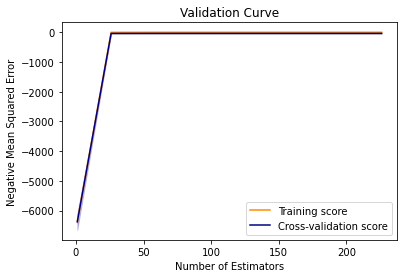

In [26]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 250, 25)  # Example: n_estimators for XGBoost
train_scores, test_scores = validation_curve(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    X=X, y=y,
    param_name='n_estimators',
    param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)

plt.plot(param_range, test_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Validation Curve")
plt.xlabel("Number of Estimators")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()


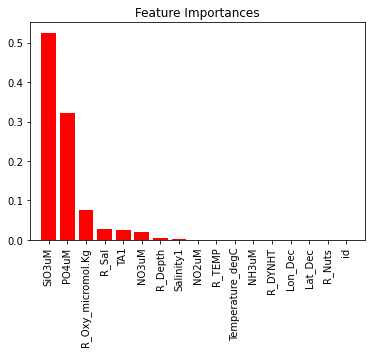

In [33]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
xgb_model.fit(X_train, y_train)

feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [34]:
test_data.columns

Index(['id', 'Lat_Dec', 'Lon_Dec', 'NO2uM', 'NO3uM', 'NH3uM', 'R_TEMP',
       'R_Depth', 'R_Sal', 'R_DYNHT', 'R_Nuts', 'R_Oxy_micromol.Kg', 'PO4uM',
       'SiO3uM', 'TA1', 'Salinity1', 'Temperature_degC'],
      dtype='object')